Importing necessary libraries

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import joblib
import time

Loading the data

In [ ]:
fraudTrain = pd.read_csv('fraudTrain.csv')
fraudTest = pd.read_csv('fraudTest.csv')


Removing unnecessary columns if they exist

In [ ]:
if 'Unnamed: 0' in fraudTrain.columns:
    fraudTrain.drop(['Unnamed: 0'], axis=1, inplace=True)
if 'trans_num' in fraudTrain.columns:
    fraudTrain.drop(['trans_num'], axis=1, inplace=True)

if 'Unnamed: 0' in fraudTest.columns:
    fraudTest.drop(['Unnamed: 0'], axis=1, inplace=True)
if 'trans_num' in fraudTest.columns:
    fraudTest.drop(['trans_num'], axis=1, inplace=True)

In [ ]:
fraudTrain['trans_date_trans_time'] = pd.to_datetime(fraudTrain['trans_date_trans_time'])
fraudTest['trans_date_trans_time'] = pd.to_datetime(fraudTest['trans_date_trans_time'])

fraudTrain['transaction_hour'] = fraudTrain['trans_date_trans_time'].dt.hour
fraudTest['transaction_hour'] = fraudTest['trans_date_trans_time'].dt.hour
fraudTrain['transaction_day'] = fraudTrain['trans_date_trans_time'].dt.dayofweek
fraudTest['transaction_day'] = fraudTest['trans_date_trans_time'].dt.dayofweek

fraudTrain.drop('trans_date_trans_time', axis=1, inplace=True)
fraudTest.drop('trans_date_trans_time', axis=1, inplace=True)

Splitting data into features and labels

In [ ]:
X_train = fraudTrain.drop('is_fraud', axis=1)
y_train = fraudTrain['is_fraud']
X_test = fraudTest.drop('is_fraud', axis=1)
y_test = fraudTest['is_fraud']

Checking for missing values in target variables

In [ ]:
if y_train.isnull().sum() > 0:
    print(f"Missing values in y_train: {y_train.isnull().sum()}")
    y_train = y_train.fillna(y_train.mode()[0])

if y_test.isnull().sum() > 0:
    print(f"Missing values in y_test: {y_test.isnull().sum()}")
    y_test = y_test.fillna(y_test.mode()[0])

Defining numerical and categorical columns, and creating preprocessing pipelines for numerical and categorical dara

In [ ]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Applying tranformations to the data

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


Logistic regression model

Plotting the ROC curve for logistic regression

In [ ]:
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Report:")
print(classification_report(y_test, y_pred_lr))
print("Logistic Regression ROC AUC Score:", roc_auc_score(y_test, y_pred_lr))

fpr_lr, tpr_lr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (area = %0.2f)' % roc_auc_score(y_test, y_pred_lr))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

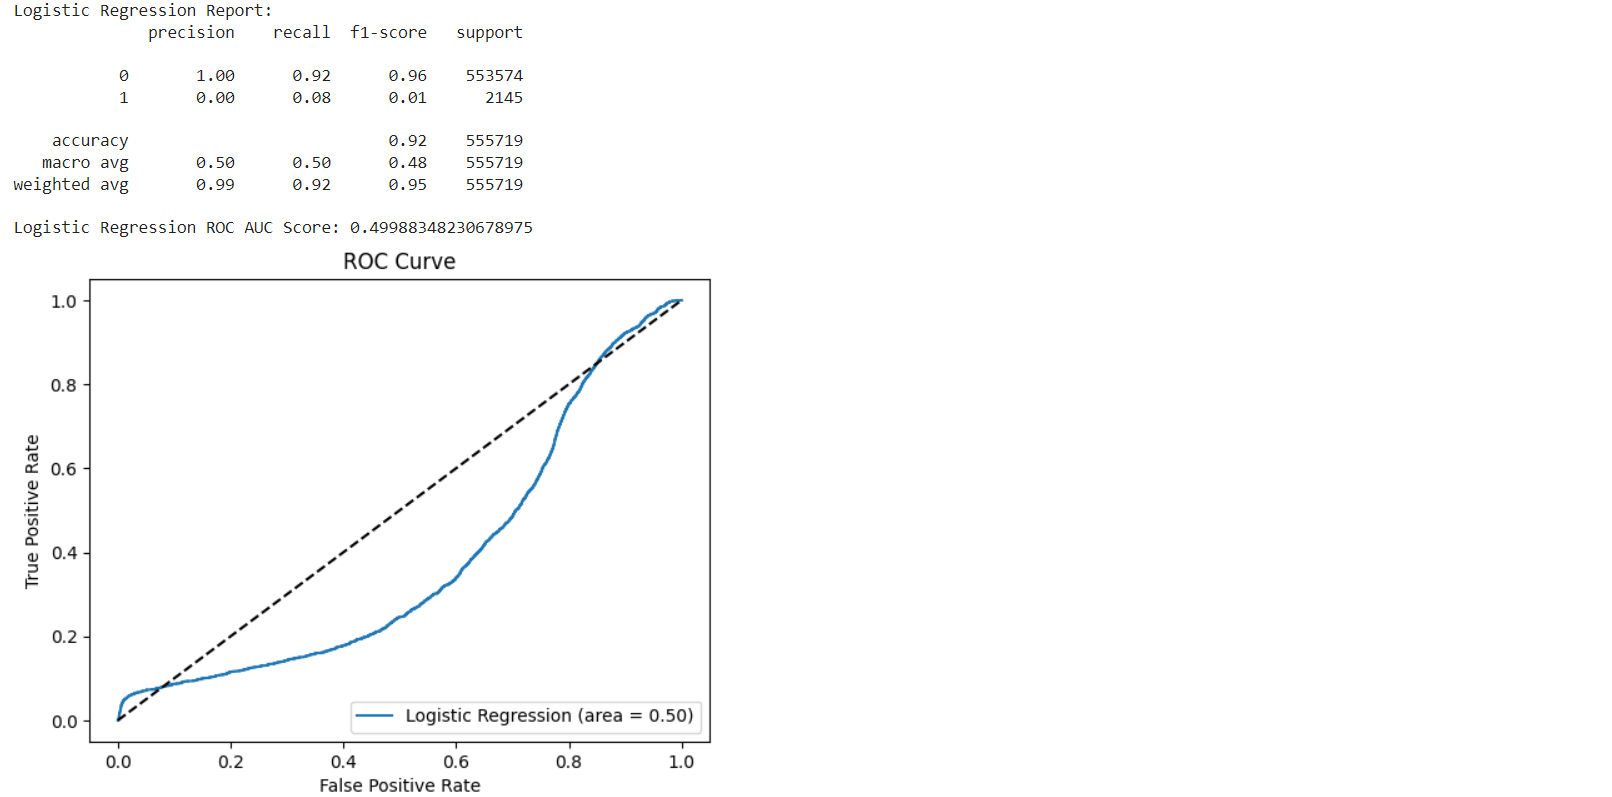

Decision tree model

Plotting the confusion matrix for decision tree model

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print("Decision Tree Report:")
print(classification_report(y_test, y_pred_dt))
print("Decision Tree ROC AUC Score:", roc_auc_score(y_test, y_pred_dt))

conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure()
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

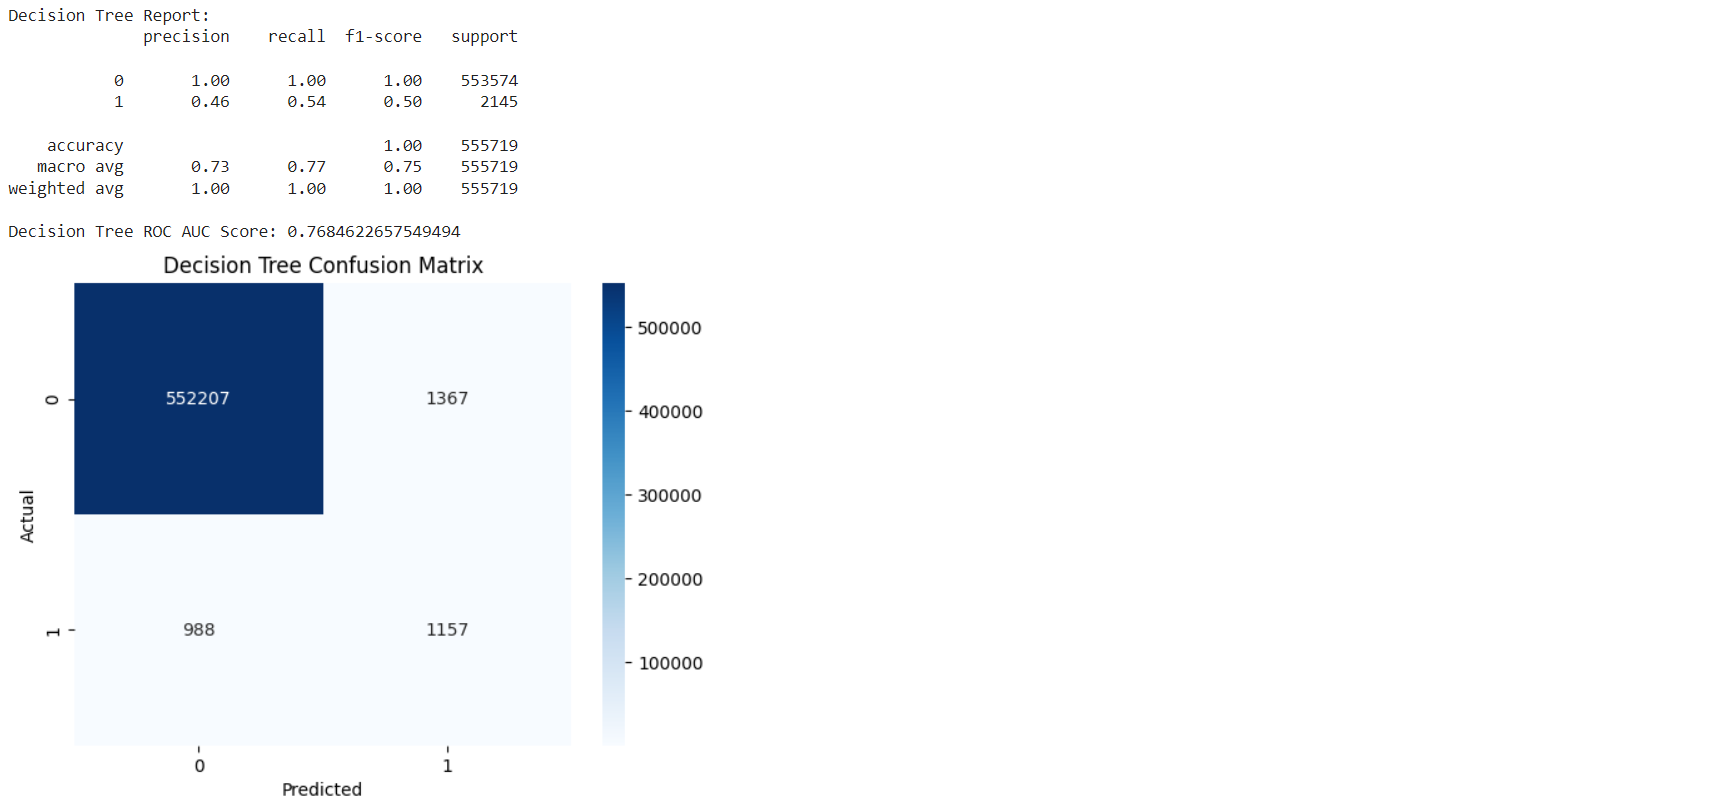

Random forest model

Plotting the feature importances for random forest using

In [ ]:
print("Training Random Forest model with class weights...")
start_time = time.time()
rf = RandomForestClassifier(n_estimators=10, max_depth=10, class_weight='balanced', n_jobs=-1)
rf.fit(X_train, y_train)
end_time = time.time()
print(f"Random Forest training completed in {end_time - start_time:.2f} seconds.")

y_pred_rf = rf.predict(X_test)
print("Random Forest Report (with class weights):")
print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC AUC Score (with class weights):", roc_auc_score(y_test, y_pred_rf))

feature_importances = rf.feature_importances_
features = numerical_cols.tolist() + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)
plt.figure()
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

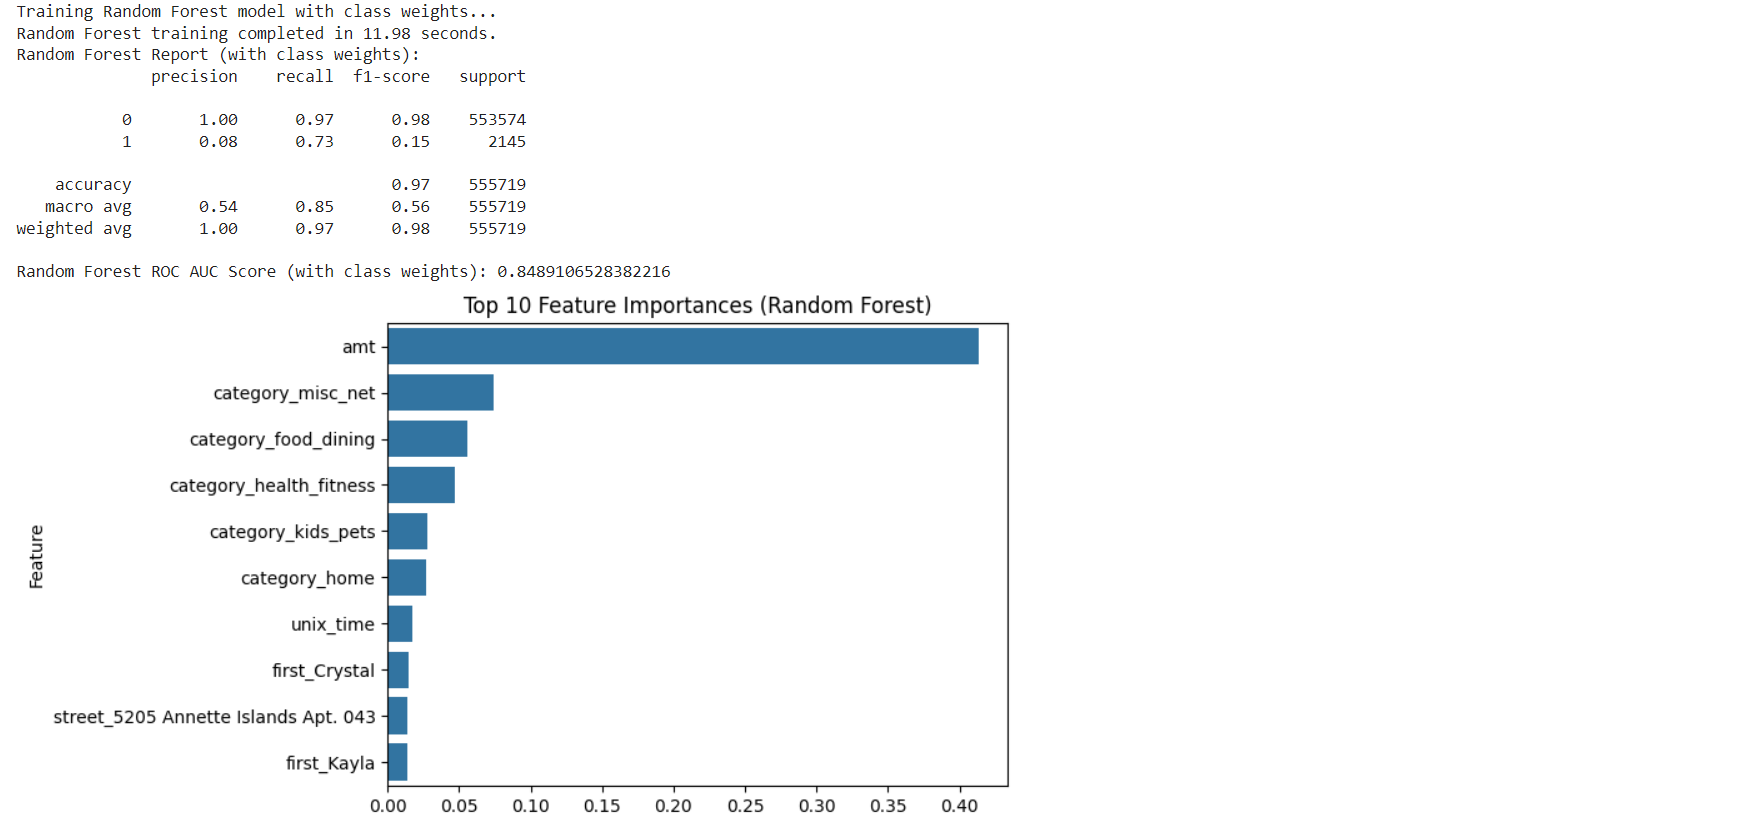

Saving the best model

In [ ]:
joblib.dump(rf, 'best_model_balanced.pkl')
print("Model saved successfully.")